# Day 7 

Running with enhanced filtering logic...

--- Final Statistics ---
The number of nodes for which you could find genres: 203
The average number of genres per node: 3.06
The total number of distinct genres: 193


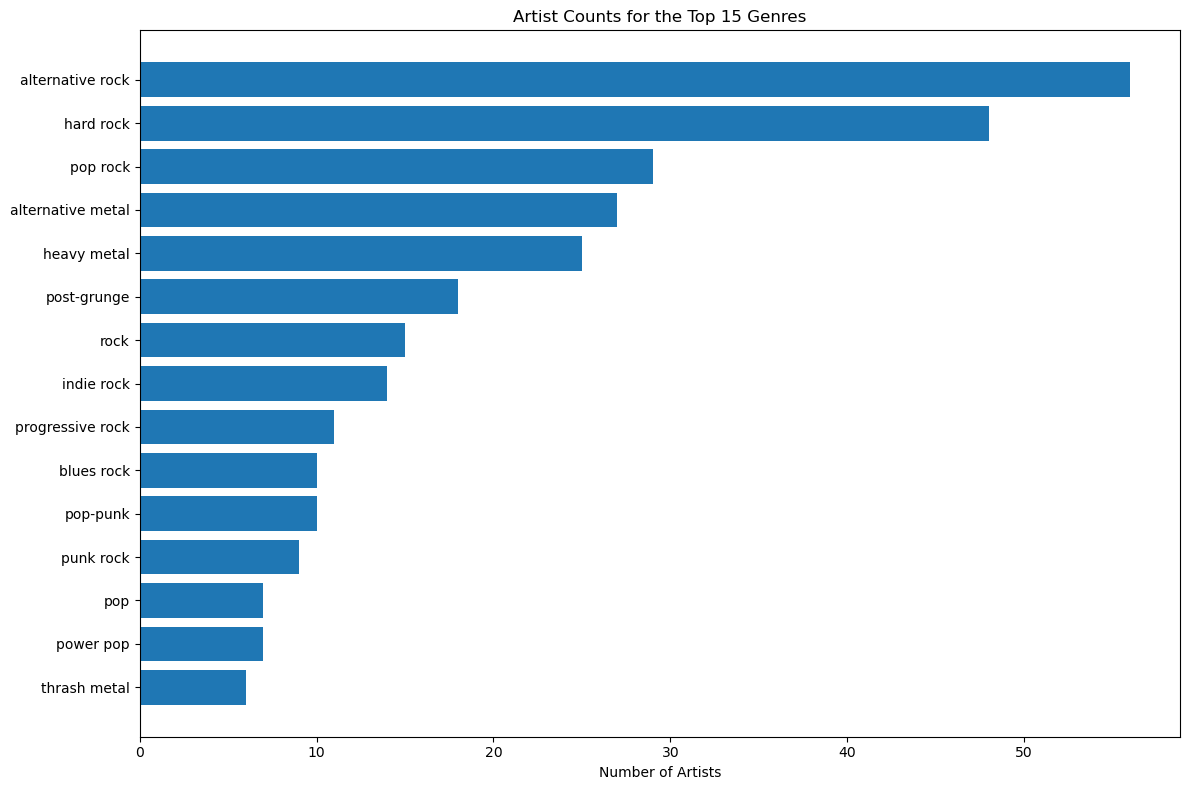

In [3]:
import os
import re
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def extract_genres_from_wikitext(wikitext, artist_name, debug=False):
    """
    Parses wikitext to find and clean genres, now with stricter filtering
    to remove non-genre junk like URLs and template fragments.
    """
    if not isinstance(wikitext, str):
        return None

    # Step 1: Find the entire infobox.
    infobox_match = re.search(r'\{\{(Infobox musical artist|Infobox band|Infobox person)(.*?)\}\}', wikitext, re.DOTALL | re.IGNORECASE)
    if not infobox_match:
        return None
    infobox_content = infobox_match.group(2)

    # Step 2: Find the genre field using our robust method.
    genre_field_match = re.search(r'\n\s*\|\s*genre\s*=', infobox_content, re.IGNORECASE)
    if not genre_field_match:
        return None

    text_after_genre = infobox_content[genre_field_match.end():]
    next_field_match = re.search(r'\n\s*\|', text_after_genre)
    
    if next_field_match:
        raw_genres = text_after_genre[:next_field_match.start()]
    else:
        raw_genres = text_after_genre

    # Step 3: Initial cleanup (this part is the same).
    raw_genres = re.sub(r'<!--.*?-->', '', raw_genres, flags=re.DOTALL)
    raw_genres = re.sub(r'<ref.*?>.*?</ref>', '', raw_genres, flags=re.DOTALL)
    raw_genres = re.sub(r'<.*?>', '', raw_genres)
    raw_genres = re.sub(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', r'\1', raw_genres)
    # More aggressive template removal
    raw_genres = re.sub(r'\{\{.*?\}\}', '', raw_genres, flags=re.DOTALL)
    raw_genres = raw_genres.replace('}}', '')

    # Step 4: Split into a list of potential genres.
    genres = re.split(r'[,/\n*]', raw_genres)

    # --- NEW & IMPROVED: FINAL FILTERING ---
    cleaned_genres = []
    # List of junk words to ignore. Can be expanded if you see more.
    junk_words = {'artist', 'web', 'website', 'title', 'url', 'cite'} 

    for genre in genres:
        genre = genre.strip().lower()
        
        # --- Quality Control Checks ---
        if not genre:
            continue  # Skip empty strings that result from splitting.
        if genre in junk_words:
            continue  # Skip common junk words.
        if '.' in genre and ('com' in genre or 'org' in genre or 'gov' in genre):
            continue  # Skip things that look like URLs.
        if any(char in genre for char in ['|', '=', '{', '}']):
            continue  # Skip leftover template fragments.
        if len(genre) > 25:
            continue # Skip overly long strings which are likely errors.
        
        # --- End of Quality Control ---

        # Standardize "rock and roll"
        if 'rock' in genre and ('&' in genre or 'and' in genre) and 'roll' in genre:
            genre = 'rock and roll'
        
        cleaned_genres.append(genre)

    return cleaned_genres if cleaned_genres else None


# --- Main Script Execution (No changes needed here) ---

bands_folder_path = r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Assignment1\bands"
artist_genres_map = {}

if not os.path.isdir(bands_folder_path):
    print(f"Error: The directory '{bands_folder_path}' does not exist.")
else:
    print("Running with enhanced filtering logic...")
    for filename in os.listdir(bands_folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(bands_folder_path, filename)
            artist_name = os.path.splitext(filename)[0].replace('_', ' ')

            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                wikitext = None
                pages = data.get('query', {}).get('pages', {})
                if pages:
                    page_id = next(iter(pages))
                    page = pages[page_id]
                    if 'revisions' in page and page['revisions'] and 'slots' in page['revisions'][0]:
                        slots = page['revisions'][0]['slots']
                        if 'main' in slots and '*' in slots['main']:
                             wikitext = slots['main']['*']
                
                if wikitext:
                    genres = extract_genres_from_wikitext(wikitext, artist_name)
                    if genres:
                        artist_genres_map[artist_name] = genres

            except Exception as e:
                print(f"An unexpected error occurred with file {filename}: {e}")

# --- Reporting Stats ---

if not artist_genres_map:
    print("\nExecution finished. Could not find any genres.")
else:
    num_nodes_with_genres = len(artist_genres_map)
    total_genres_found = sum(len(g) for g in artist_genres_map.values())
    average_genres_per_node = total_genres_found / num_nodes_with_genres
    all_genres = [genre for genres in artist_genres_map.values() for genre in genres]
    total_distinct_genres = len(set(all_genres))

    print("\n--- Final Statistics ---")
    print(f"The number of nodes for which you could find genres: {num_nodes_with_genres}")
    print(f"The average number of genres per node: {average_genres_per_node:.2f}")
    print(f"The total number of distinct genres: {total_distinct_genres}")

    genre_counts = Counter(all_genres)
    top_15_genres = genre_counts.most_common(15)

    if top_15_genres:
        genres, counts = zip(*top_15_genres)
        plt.figure(figsize=(12, 8))
        y_pos = np.arange(len(genres))
        plt.barh(y_pos, counts, align='center')
        plt.yticks(y_pos, labels=genres)
        plt.gca().invert_yaxis()
        plt.xlabel('Number of Artists')
        plt.title('Artist Counts for the Top 15 Genres')
        plt.tight_layout()
        plt.show()